# Lab 10: Convolutional Neural Networks

#### Pranisaa Charnparttaravanit
#### st121720

Today we'll experiment with CNNs. We'll start with a hand-coded CNN structure based on numpy, then we'll move to PyTorch.

## Hand-coded CNN

This example is based on [Ahmed Gad's tutorial](https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html).

We will implement a very simple CNN in numpy. The model will have
just three layers, a convolutional layer (conv for short), a ReLU activation layer, and max pooling. The major steps involved are as follows.
1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking the conv, ReLU, and max pooling layers.

### Reading an input image
 
The following code reads an existing image using the SciKit-Image Python library and converts it into grayscale. You may need to `pip install scikit-image`.

======= original image shape =======
Image dimensions: (300, 451, 3)


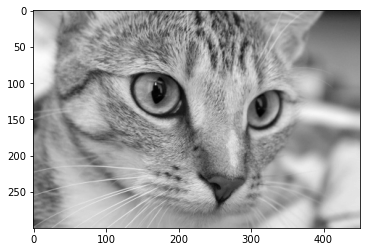

======= rbg2g image shape =======
(300, 451)


In [1]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read image

img = skimage.data.chelsea()
print('======= original image shape =======')
print('Image dimensions:', img.shape)

# Convert to grayscale

img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()
print('======= rbg2g image shape =======')
print(img.shape)

### Create some filters for the conv layer

Recall that a conv layer uses some number of convolution (actually cross correlation) filters, usually matching the number
of channels in the input (1 in our case since the image is grayscale). Each kernel gives us one feature map (channel) in the
result.

Let's make two 3$\times$3 filters, using the horizontal and vertical Sobel edge filters:

In [2]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])

print(l1_filters)

l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])
print(l1_filters)

[[[-1.  0.  1.]
  [-2.  0.  2.]
  [-1.  0.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
[[[-1.  0.  1.]
  [-2.  0.  2.]
  [-1.  0.  1.]]

 [[-1. -2. -1.]
  [ 0.  0.  0.]
  [ 1.  2.  1.]]]


### Conv layer feedforward step
 
Let's convolve the input image with our filters.

In [3]:
# Perform stride 1 cross correlation of an image and a filter. We output the valid region only
# (no padding).

def convolve(img, conv_filter):
    stride = 1
    padding = 0
    filter_size = conv_filter.shape[1] #3
    results_dim = ((np.array(img.shape) - np.array(conv_filter.shape) + (2*padding))/stride) + 1
#     print('result_dim',results_dim)
    result = np.zeros((int(results_dim[0]), int(results_dim[1])))
    
    for r in np.arange(0, img.shape[0] - filter_size + 1):
        for c in np.arange(0, img.shape[1]-filter_size + 1):          
            curr_region = img[r:r+filter_size,c:c+filter_size] # region of the image when filter is placed on top
#             print('image region',f'ima[{r}:{r+filter_size},{c}:{c+filter_size}]')
#             print('conv_filter',conv_filter)
            curr_result = curr_region * conv_filter
#             print('curr_result',curr_result)
            conv_sum = np.sum(curr_result)
#             print('conv_sum', conv_sum)
            result[r, c] = conv_sum
#             print(f'result[{r},{c}]')
            
    return result       

# Perform convolution with a set of filters and return the result

def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        ### if more complex
        if img.shape[-1] != conv_filters.shape[-1]:
            ####451 != 3
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: ###### should be odd (center spot)
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]
#         print('len curr filter .shape',len(curr_filter.shape))
        # Our convolve function only handles 2D convolutions. If the input has multiple channels, we
        # perform the 2D convolutions for each input channel separately then add them. If the input
        # has just a single channel, we do the convolution directly.
        if len(curr_filter.shape) > 2: #loop at different chanels if more than2D conv
            conv_map = convolve(img[:, :, 0], curr_filter[:, :, 0])
            print('in this loop')
            for ch_num in range(1, curr_filter.shape[-1]): #add them  after conv 
                conv_map = conv_map + convolve(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve(img, curr_filter) #else just do normal 2D, so no need to sum
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

Let's give it a try:

2
451
3
3
Convolutional feature maps shape: (298, 449, 2)


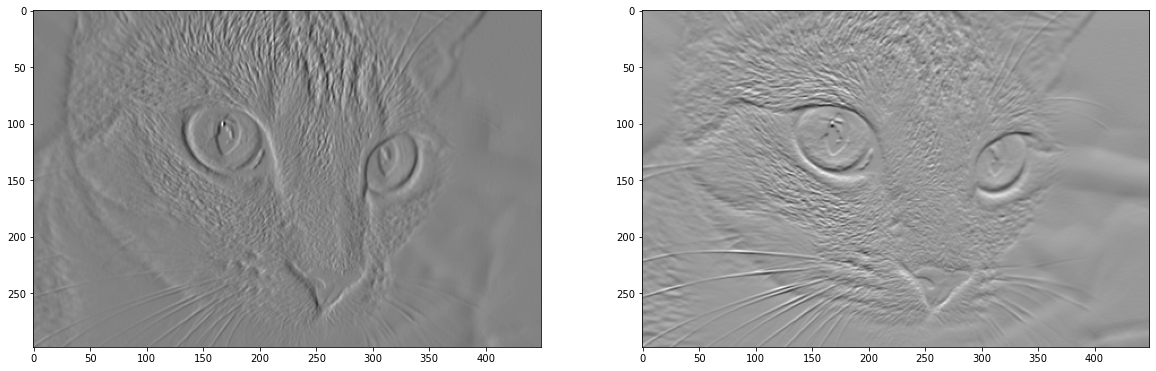

time taken:  5.211541750992183


In [4]:
import timeit
starttime = timeit.default_timer()
features = conv(img, l1_filters)
timetaken = timeit.default_timer()-starttime

print(len(img.shape))
print(img.shape[-1])
print(len(l1_filters.shape))
print(l1_filters.shape[-1])

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()
print('time taken: ', timetaken)

Cool, right? A couple observations:
1. We've hard coded the values in the filters, so they are sensible to us. In a real CNN, we'd be tuning the filters to minimize loss on the training set, so we wouldn't expect such perfectly structured results.
2. Naive implementation of 2D convolutions requires 4 nested loops, which is super slow in Python. In the code above, we've replaced the two inner loops with an element-by-element matrix multiplication for the kernel and the portion of the image applicable for the current indices into the convoution result.

### In-class exercise

The semi-naive implementation of the convolution function above could be sped up with the use of a fast low-level 2D convolution routine that makes the best possible use of the CPU's optimized instructions, pipelining of operations, etc. Take a look at [Laurent Perrinet's blog on 2D convolution implementations](https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html) and see how the two fastest implementations,
scikit and numpy, outperform other methods and should vastly outperform the Python loop above. Reimplement the convolve() function above and compare
the times taken by the naive and optimized versions of your convolution operation for the cat image. In your report, briefly describe the experiment and the
results you obtained.

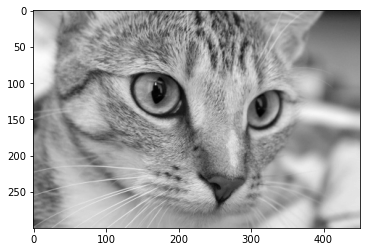

======= rbg2g image shape =======
(300, 451)


In [5]:
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()
print('======= rbg2g image shape =======')
print(img.shape)

In [6]:
m,N = img.shape
n_N = 2
M = 3
n_M = 2

def get_data(m=m,N=N, n_N=n_N, M=M, n_M=n_M, seed=42, prefetching=False):
    np.random.seed(seed)
    if prefetching:
        A = np.zeros((n_N,m, N))
        A[0, :, :] = img
        A[1, :, :] = img
        B = np.zeros((n_M, M, M))
        B[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
        B[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])
        C = np.zeros((n_N, n_M, m, N))
    else:
        A = np.random.rand(m, N, n_N)
        A[:, :, 0] = img
        A[:, :, 1] = img
        B = np.zeros((M, M, n_M))
        B[:, :, 0] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
        B[:, :, 1] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])        
        C = np.zeros((m, N, n_N, n_M))
    return A, B, C

for prefetching in [True, False]:
    print ('with prefetching=', prefetching)
    A, B, C = get_data(prefetching=prefetching)
    print('Checking size of A =', A.shape, ' of B=', B.shape, ', and of C=', C.shape)
    
def test_get_data(m=m,N=N, n_N=n_N, M=M, n_M=n_M):
    A, B, C = get_data(m,N, n_N, M, n_M)  

test_get_data(m,N, n_N, M, n_M)

with prefetching= True
Checking size of A = (2, 300, 451)  of B= (2, 3, 3) , and of C= (2, 2, 300, 451)
with prefetching= False
Checking size of A = (300, 451, 2)  of B= (3, 3, 2) , and of C= (300, 451, 2, 2)


In [7]:
### numpy
from numpy.fft  import fft2, ifft2
def np_fftconvolve(A, B):
    return np.real(ifft2(fft2(A)*fft2(B, s=A.shape)))

def test_numpy_fft(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = np_fftconvolve(A[i_N, :, :], B[i_M, :, :])
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = np_fftconvolve(A[:, :, i_N], B[:, :, i_M])  


In [8]:
#### scikit
from skimage.feature import match_template
def test_skimage(A, B, C, prefetching=False):
    if prefetching:
        for i_N in np.arange(A.shape[0]):
            for i_M in np.arange(B.shape[0]):
                C[i_N, i_M, :, :] = match_template(A[i_N, :, :], B[i_M, :, :], pad_input=True, mode='constant', constant_values=0.)
    else:
        for i_N in np.arange(A.shape[-1]):
            for i_M in np.arange(B.shape[-1]):
                C[:, :, i_N, i_M] = match_template(A[:, :, i_N], B[:, :, i_M], pad_input=True, mode='constant', constant_values=0.)                            


In [9]:
m,N = img.shape
n_N = 2
M = 3
n_M = 2

In [10]:
%%timeit
features = conv(img, l1_filters)

5.07 s ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
A, B, C = get_data(m=m,N=N, n_N=n_N, M=M, n_M=n_M)

In [12]:
%%timeit
test_numpy_fft(A, B, C)

82.4 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
test_skimage(A, B, C)

80.5 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
A, B, C = get_data(m=m,N=N, n_N=n_N, M=M, n_M=n_M, prefetching=True)

In [15]:
%%timeit
test_numpy_fft(A, B, C, prefetching=True)

77.1 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
test_skimage(A, B, C, prefetching=True)

73.4 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Report

As for my in-class exercise, i have implemented numpy as well as scikit learn methods. Both of which allow us to prefetching as well as not prefetching our input data.
After i implemented the codes as shown above, i have timed how long it takes to complete the task. That means in total i should have 5 different times to compare.

As a result, it is clear to see that our method is the slowest with the time of 5.05 seconds followed by numpy and skicit learn methods.
Moreover, we can also observe that prefetching the data improves the time taken.


### Pooling and relu

Next, consider the feedforward pooling and ReLU operations.

In [17]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2): #size of max = 2x2
    # Unsigned integer (0 to 18446744073709551615)
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]): # the last dimension of feature_map is the number of filters
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride): #step moving by number of stride
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

Now let's try ReLU and pooling:

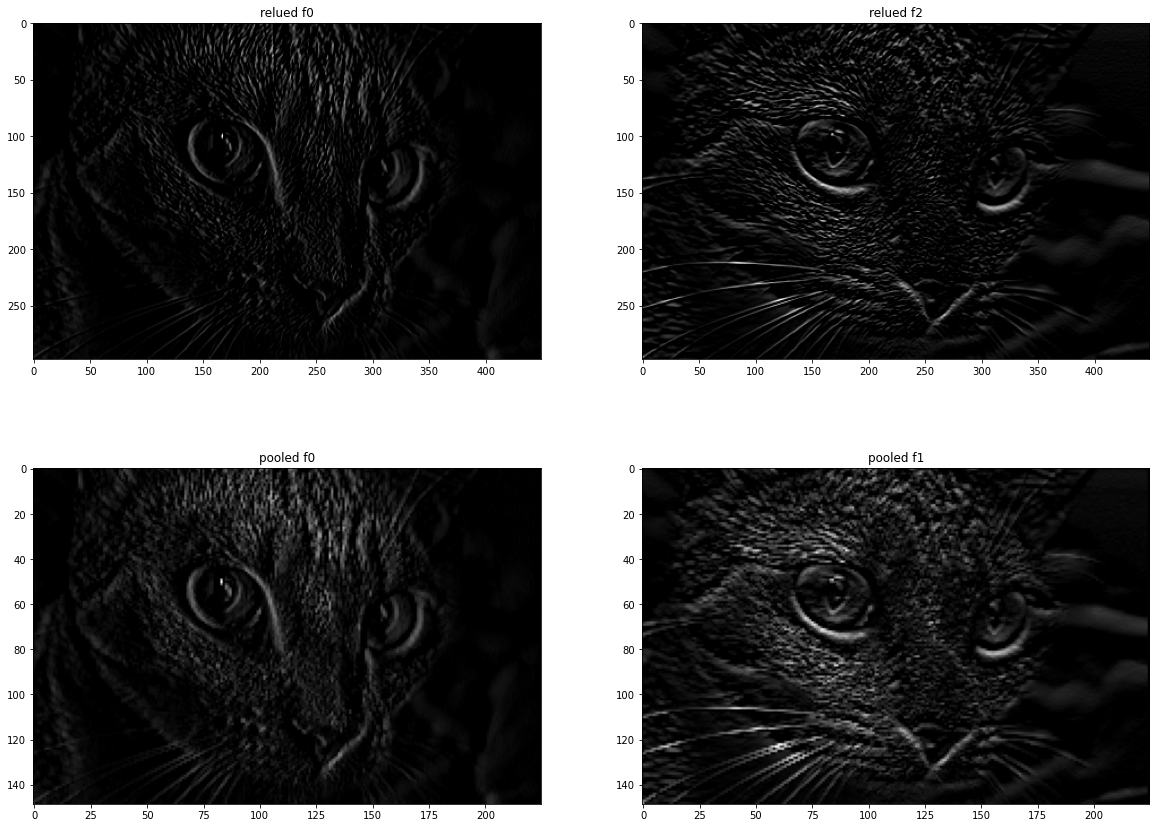

In [18]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax1.set_title('relued f0')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax2.set_title('relued f2')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax3.set_title('pooled f0')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
ax4.set_title('pooled f1')
plt.show()


Let's visualize all of the feature maps in the model...

In [19]:
# First conv layer

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
print('l1_feature_maps',l1_feature_maps.shape)
l1_feature_maps_relu = relu(l1_feature_maps)
print('l1_feature_maps_relu',l1_feature_maps_relu.shape)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)
print('l1_feature_maps_relu_pool',l1_feature_maps_relu_pool.shape)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
print('l2_filters',l2_filters.shape)
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
print('l2_feature_maps',l2_feature_maps.shape)
l2_feature_maps_relu = relu(l2_feature_maps)
print('l2_feature_maps_relu',l2_feature_maps_relu.shape)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
print('l2_feature_maps_relu_pool',l2_feature_maps_relu_pool.shape)
# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
print('l3_filters',l3_filters.shape)
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
print('l3_feature_maps',l3_feature_maps.shape)
l3_feature_maps_relu = relu(l3_feature_maps)
print('l3_feature_maps_relu',l3_feature_maps_relu.shape)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)
print('l3_feature_maps_relu_pool',l3_feature_maps_relu_pool.shape)

conv layer 1...
l1_feature_maps (298, 449, 2)
l1_feature_maps_relu (298, 449, 2)
l1_feature_maps_relu_pool (149, 225, 2)
conv layer 2...
l2_filters (3, 5, 5, 2)
in this loop
in this loop
in this loop
l2_feature_maps (145, 221, 3)
l2_feature_maps_relu (145, 221, 3)
l2_feature_maps_relu_pool (73, 111, 3)
conv layer 3...
l3_filters (1, 7, 7, 3)
in this loop
l3_feature_maps (67, 105, 1)
l3_feature_maps_relu (67, 105, 1)
l3_feature_maps_relu_pool (34, 53, 1)


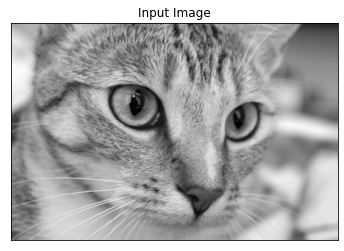

In [20]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()


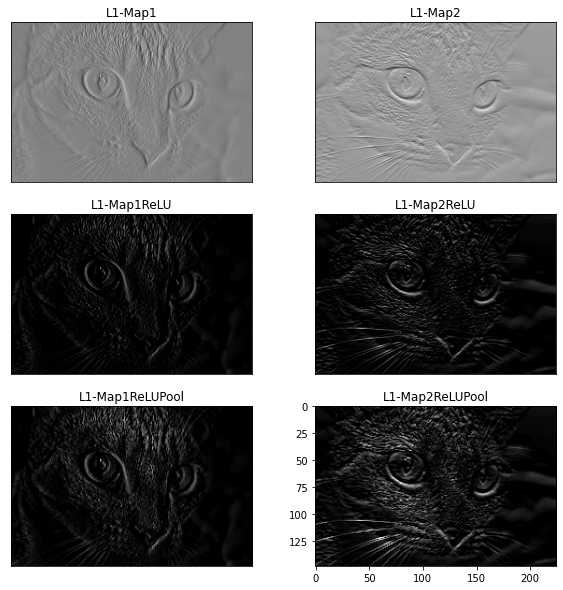

In [21]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()


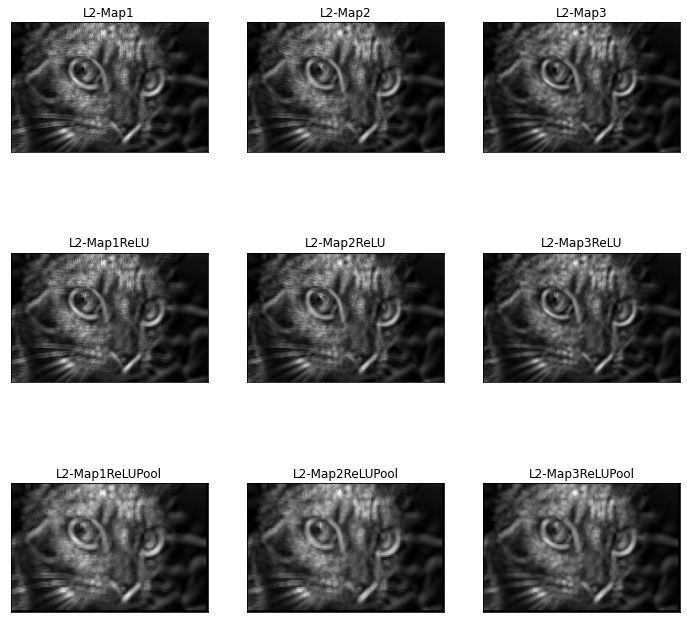

In [22]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

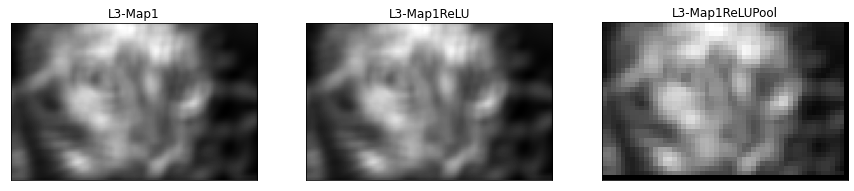

In [23]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()

We can see that at progressively higher layers of the network, we get coarser representations of the input. Since the filters at the later layers
are random, they are not very structured, so we get a kind of blurring effect. These visualizations would be more meaningful in model with learned
filters.

## CNNs in PyTorch

Now we'll do a more complete CNN example using PyTorch. We'll use the MNIST digits again. The example is based on
[Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

PyTorch has a few useful modules for us:
1. cuda: GPU-based tensor computations
2. nn: Neural network layer implementations and backpropagation via autograd
3. torchvision: datasets, models, and image transformations for computer vision problems.

torchvision itself includes several useful elements:
1. datasets: Datasets are subclasses of torch.utils.data.Dataset. Some of the common datasets available are "MNIST," "COCO," and "CIFAR." In this example we will see how to load MNIST dataset using a custom subclass of the datasets class.
2. transforms - Transforms are used for image transformations. The MNIST dataset from torchvision is in PIL image. 
To convert MNIST images to tensors, we will use `transforms.ToTensor()`.

In [24]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

### Load the MNIST data

First, let's load the data and transfrom the input elements (pixels) so that their mean over the entire training dataset is 0 and its standard deviation is 1.

In [25]:
# Desired mean and standard deviation

mean = 0.0
stddev = 1.0

# Transform input image

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean,), (stddev,))])

#transform.Normalize((mean,mean,mean),(stddev,stddev,stddev)) 
#Since its an image, we are sending 3 values of mean and 3 values of std, 
#for each color channels of RGB.

import os

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [26]:
print(mnist_train.data.shape)
print(mnist_train.data[1].shape)
print(mnist_train.data.numpy().shape)
print(mnist_train.data[1].numpy().shape)
# print(mnist_train.data[1])
# print(mnist_train.data[1].numpy())

torch.Size([60000, 28, 28])
torch.Size([28, 28])
(60000, 28, 28)
(28, 28)


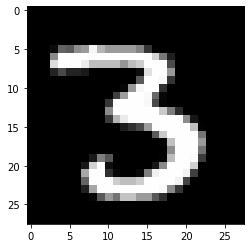

In [27]:
# convert to numpy because imshow takes numpy
img = mnist_train.data[12].numpy()
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

In [28]:
# index 1 = label
label = mnist_train[12][1]
print('Label of image above:', label)

# Reduce batch size if you get out-of-memory error

batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)


#DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
#            batch_sampler=None, num_workers=0, collate_fn=None,
#            pin_memory=False, drop_last=False, timeout=0,
#            worker_init_fn=None, *, prefetch_factor=2,
#            persistent_workers=False)
#the drop_last argument drops the last non-full batch of each worker’s iterable-style dataset replica.


Label of image above: 3


### Define the NN model

We use 2 convolutional layers followed by 2 fully connected layers. The input size of each image is (28,28,1). We will use stide of size 1 and padding of size 0.

For first convolution layer we will apply 20 filters of size (5,5).   CNN output formula $$\text{output size} = \frac{W - F + 2P}{S} + 1$$ where $W$ - input, $F$ - filter size, $P$ - padding size and $S$ - stride size.

We get $\frac{(28,28,1) - (5,5,1) + (2*0)}{1} + 1$ for each filter, so for 10 filters we get output size of (24,24,10).

The ReLU activation function is applied to the output of the first convolutional layer.

For the second convolutional layer, we apply 20 filters of size (5,5), giving us output of size of (20,20,20). Maxpooling with a size of 2 is applied to the output of the second convolutional layer, thereby giving us an output size of of (10,10,20). The ReLU activation function is applied to the output of the maxpooling layer.

Next we have two fully connected layers. The input of the first fully connected layer is flattened output of $10*10*20 = 2000$, with 50 nodes. The second layer is the output layer and has 10 nodes.

In [29]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)     # 20 x 20 x 20  (after 2nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 20  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(2000, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 2000) #flatten
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

#### Create the objects

In [30]:
# The model
net = CNN_Model()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

#### Training loop

In [31]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
#  1 epoch = 10 iters

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader): # one batch at a time
        
        # Convert torch tensor to Variable
        items = Variable(items)
        # x = Variable(torch.ones(2, 2), requires_grad=True) <-- if grad is required default = False
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        # Every time a variable is back propogated through, 
        #the gradient will be accumulated instead of being replaced. 
        outputs = net(items)      # Do the forward pass >>> our pixel data with batch-size of 1000
#         print('output')
#         print(outputs.shape)
#         print(classes)
        #pytorch converts outputs to the right format for you
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss >>> each iteration do all batches
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
# When you call loss.backward(), all it does is compute gradient of loss w.r.t 
# all the parameters in loss that have requires_grad = True 
# and store them in parameter.grad attribute for every parameter.

# optimizer.step() updates all the parameters based on parameter.grad

        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        # the result tuple of two output tensors (max, max_indices).
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations) #average loss per iter to store as loss per epoch
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader): #mnist_valie_loader is our test set
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 1.6596, Tr Acc: 48.0000, Val Loss: 0.4980, Val Acc: 85.8500
Epoch 2/20, Tr Loss: 0.3975, Tr Acc: 88.0000, Val Loss: 0.3061, Val Acc: 91.1700
Epoch 3/20, Tr Loss: 0.2937, Tr Acc: 91.0000, Val Loss: 0.2377, Val Acc: 92.5900
Epoch 4/20, Tr Loss: 0.2371, Tr Acc: 92.0000, Val Loss: 0.2007, Val Acc: 93.9000
Epoch 5/20, Tr Loss: 0.2020, Tr Acc: 93.0000, Val Loss: 0.1875, Val Acc: 94.0800
Epoch 6/20, Tr Loss: 0.1734, Tr Acc: 94.0000, Val Loss: 0.1566, Val Acc: 95.2800
Epoch 7/20, Tr Loss: 0.1506, Tr Acc: 95.0000, Val Loss: 0.1344, Val Acc: 95.9600
Epoch 8/20, Tr Loss: 0.1308, Tr Acc: 95.0000, Val Loss: 0.1193, Val Acc: 96.4500
Epoch 9/20, Tr Loss: 0.1154, Tr Acc: 96.0000, Val Loss: 0.1052, Val Acc: 96.9900
Epoch 10/20, Tr Loss: 0.1076, Tr Acc: 96.0000, Val Loss: 0.0939, Val Acc: 97.1200
Epoch 11/20, Tr Loss: 0.0935, Tr Acc: 97.0000, Val Loss: 0.0859, Val Acc: 97.3900
Epoch 12/20, Tr Loss: 0.0855, Tr Acc: 97.0000, Val Loss: 0.0810, Val Acc: 97.5000
Epoch 13/20, Tr Loss: 0.0

In [32]:
a = torch.randn(4, 4)
print(a)
print(torch.max(a, 1))
#the result tuple of two output tensors (max, max_indices).

tensor([[ 0.2201, -0.4990, -0.4530, -0.3089],
        [ 0.2190, -1.9323, -1.8223, -0.5487],
        [-0.2757,  2.9591, -0.1059, -0.3474],
        [-0.4321, -1.5111, -0.9087, -1.6789]])
torch.return_types.max(
values=tensor([ 0.2201,  0.2190,  2.9591, -0.4321]),
indices=tensor([0, 0, 1, 0]))


We can see that the model is still learning something. We might want to train another 10 epochs or so to see if validation accuracy increases further. For now, though, we'll just save the model.

In [33]:
# save the model
torch.save(net.state_dict(), "./3.model.pth")

Next, let's visualize the loss and accuracy

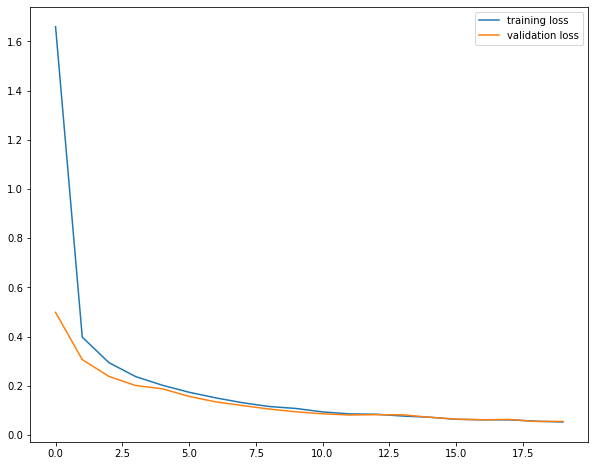

In [34]:
# Plot loss curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

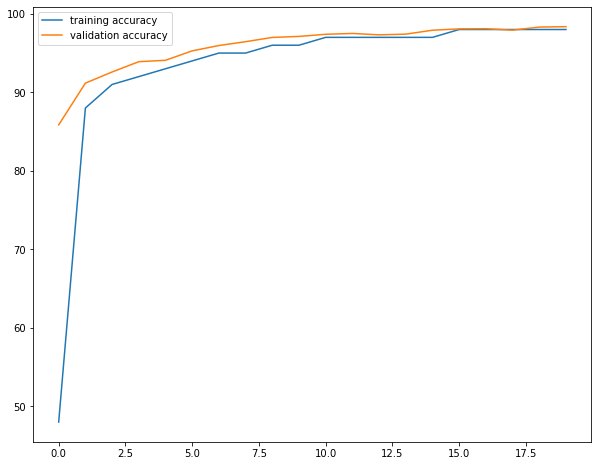

In [35]:
# Plot accuracy curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

What can you conclude from the loss and accuracy curves?
1. We are not overfitting (at least not yet)
2. We should continue training, as validation loss is still improving
3. Validation accuracy is much higher than last week's fully connected models

Now let's test on a single image.

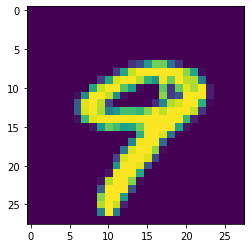

In [36]:
image_index = 9
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]
plt.imshow(img[0,0])
net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)

In [37]:
output

tensor([[ -4.7498, -13.2844,  -2.2665,   3.1948,   2.3599,  -1.5021,  -9.8265,
           6.2121,   5.3173,  12.9758]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [38]:
_, predicted = torch.max(output.data, 1)
print(predicted)
print("Predicted label:", predicted[0].item())
print("Actual label:", label)

tensor([9], device='cuda:0')
Predicted label: 9
Actual label: 9
